In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import os
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from tensorflow.keras.models import load_model
import random
import glob
import re
import nibabel as nib
from collections import defaultdict
from tensorflow.keras.optimizers import Adam, SGD,Adagrad
from tensorflow.compat.v1 import reset_default_graph
from sklearn.model_selection import KFold
# from DataLoader import dataGenerator,getIcelandicData,getIXIData,getUKBData
# from Util import plotData,getPredictions,loadMR,loadHeader,calculateMeanImg
import ResNet
from ResNet import generateAgePredictionResNet
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping 
from tensorflow.python.keras import backend as K
import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()
# tf.disable_v2_behavior()
from tensorflow.keras.models import load_model
import imp
imp.reload(ResNet)

2023-07-17 13:45:03.611215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 13:45:03.998668: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 13:45:04.001020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 13:45:05.674157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'ResNet' from '/media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging_Project/Code/Brain_Age_Estimation/DL_based_BAE/ResNet/ResNet.py'>

In [2]:
dataShape = (121, 145, 121)

In [20]:
vbm_dir = "/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/train/cat12_vbm"
vbm_files = glob.glob(os.path.join(vbm_dir, "*.npy"))
metadata_path = "/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Subjects/participants_openbhb.csv"

X = np.empty((20,dataShape[0],dataShape[1],dataShape[2],1))
Ids = []
for i in range(20):
    id_i = re.search("sub-(.*)_prep", str(vbm_files[i])).group(1)
    X[i,:,:,:,:] = np.load(vbm_files[i]).reshape(dataShape+(1,))
    Ids.append(id_i)
    if (i%5==0):
        print(i," files loaded...")

X.shape, Ids

0  files loaded...
5  files loaded...
10  files loaded...
15  files loaded...


((20, 121, 145, 121, 1),
 ['475943000000',
  '100053000000',
  '100264000000',
  '100479000000',
  '100536464191',
  '100544000000',
  '101405000000',
  '101428024622',
  '101942000000',
  '102730000000',
  '103116000000',
  '103327000000',
  '104230000000',
  '104626000000',
  '104655000000',
  '104757000000',
  '104775000000',
  '104894000000',
  '105046731194',
  '105288000000'])

In [16]:
# np.save("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Test/VBM_OpenBHB.npy",X)
OpenBHB_Metadata = getOpenBHBLabels(Ids,metadata_path)
OpenBHB_Metadata.to_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Test/OpenBHB_Metadata.csv")

In [7]:
def getOpenBHBLabels(IDs, metadata_path):
    metadata = pd.read_csv(metadata_path, sep="\t")
    if (type(IDs)!="pandas.core.frame.DataFrame"):
        IDs = pd.DataFrame({"participant_id":Ids}, dtype=float)
    merged = IDs.merge(metadata, left_on="participant_id", right_on="participant_id", how="inner")
    return merged.loc[:,["participant_id", "age", "sex"]]


In [61]:
# Y = getOpenBHBLabels(Ids, metadata_path)
# X_new = np.concatenate((X_train, X_train))
# Y.iloc[:int(len(Y)/2),:].shape
X[int(len(X)/2):,:,:,:,:].shape

# X_train, X_test, Y_train, Y_test = train_test_split(X[:int(len(X)/2),:,:,:,:], Y.loc[:int(len(Y)/2)-1,"age"], test_size=0.2)

# Y = Y.loc[int(len(Y)/2)-1:,"age"]
# Y.shape


(10, 121, 145, 121, 1)

#### Training

In [34]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y.loc[:,"age"], test_size=0.2)

nEpochs=500
batchSize = 4
steps_per_epoch= X_train.shape[0]//batchSize
validation_steps = X_test.shape[0]//batchSize

In [6]:
default_parameters = [0.001,1e-6,'RawImg','IncludeGender','IncludeScanner',0.00005,0.2,40,10]
lr, decayRate, meanImg, gender, scanner,regAmount, dropRate, maxAngle,maxShift = default_parameters

model = generateAgePredictionResNet(dataShape,regAmount=regAmount,dropRate=dropRate)
#lr=0.001
#decayRate=1e-6
#momentum=0.9
adam = Adam(learning_rate=lr)
model.compile(loss='mean_absolute_error',optimizer=adam, metrics=['mae','mse'])

2023-07-14 11:53:19.746708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 T1_Img (InputLayer)         [(None, 121, 145, 121, 1)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 121, 145, 121, 8)     224       ['T1_Img[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 121, 145, 121, 8)     56        ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 elu (ELU)                   (None, 121, 145, 121, 8)     0         ['batch_normalization[0][0

In [ ]:
mc = ModelCheckpoint('../Models/BrainAgeResNet({}-Ice)'.format(imageType),verbose=1,mode='min',save_best_only=True)
early = EarlyStopping(patience=100, verbose=1)

In [97]:
h = model.fit(x=X_train, y=Y_train,
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch, 
                        epochs=nEpochs,
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False
                        # callbacks=[mc,early]
                           )

Epoch 1/500


2023-07-14 13:42:09.874673: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1358684800 exceeds 10% of free system memory.
2023-07-14 13:42:33.453526: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1834224480 exceeds 10% of free system memory.
2023-07-14 13:42:33.465157: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1834224480 exceeds 10% of free system memory.


 1/40 [..............................] - ETA: 20:57 - loss: 27.6584 - mae: 27.5959 - mse: 791.4849

2023-07-14 13:42:56.969955: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1834224480 exceeds 10% of free system memory.
2023-07-14 13:42:56.976485: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1834224480 exceeds 10% of free system memory.


40/40 [==============================] - 913s 23s/step - loss: 31.8546 - mae: 31.7910 - mse: 4746.8169
Epoch 2/500
40/40 [==============================] - 893s 22s/step - loss: 11.1311 - mae: 11.0666 - mse: 264.9225
Epoch 3/500
40/40 [==============================] - 871s 22s/step - loss: 10.0588 - mae: 9.9943 - mse: 233.9284
Epoch 4/500
40/40 [==============================] - 864s 22s/step - loss: 9.1333 - mae: 9.0689 - mse: 207.8861
Epoch 5/500
40/40 [==============================] - 865s 22s/step - loss: 10.1160 - mae: 10.0516 - mse: 234.2104
Epoch 6/500
40/40 [==============================] - 865s 22s/step - loss: 8.9760 - mae: 8.9116 - mse: 201.1225
Epoch 7/500
40/40 [==============================] - 864s 22s/step - loss: 9.4610 - mae: 9.3966 - mse: 221.1519
Epoch 8/500
40/40 [==============================] - 864s 22s/step - loss: 9.2503 - mae: 9.1858 - mse: 203.2021
Epoch 9/500
40/40 [==============================] - 866s 22s/step - loss: 9.3774 - mae: 9.3126 - mse: 181.9

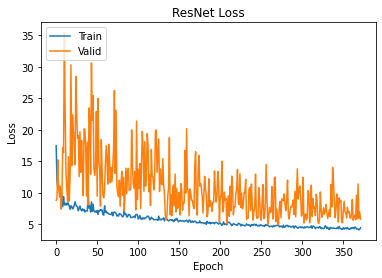

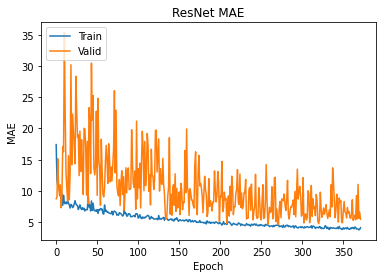

In [11]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])
plt.title('ResNet MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

In [12]:
model.save('../Models/BrainAgeResNet({}-Ice-TrainedFor{}Epochs)'.format(imageType,len(h.history['loss'])))

In [13]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
val_prediction = model.predict(dataGenerator([val.Loc.values,scanner_val,gender_val],val.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False
                        )

test_prediction = model.predict(dataGenerator([test.Loc.values,test.Scanner.values,test.Gender.values],test.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False
                        )

358/358 [==============================] - 37s 103ms/step


Validation R^2:  0.7196718781385278
Validation MAE:  4.673956568176682


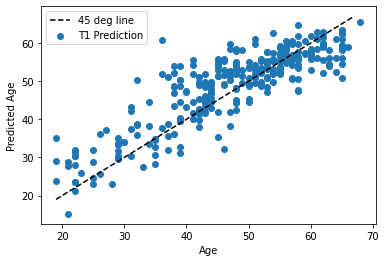

Test R^2:  0.7193893399789004
Test MAE:  4.822677740171635


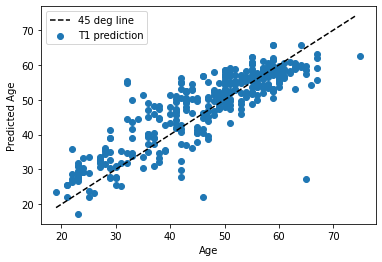

In [15]:
predictions = val_prediction[:,0]
yVal = val.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

predictions = test_prediction[:,0]
yTest = test.Age.values

print('Test R^2: ',r2_score(yTest,predictions))
print('Test MAE: ',mean_absolute_error(yTest,predictions))
y_range = np.arange(np.min(yTest),np.max(yTest))
plt.scatter(yTest,predictions,label='T1 prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

#### Transfer learning on IXI

In [15]:
ixiMeanImg = calculateMeanImg(train_IXI.Loc.values)

0 done
250 done


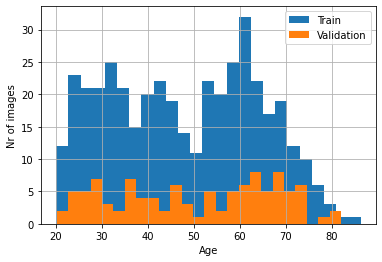

In [12]:
train_IXI.Age.hist(bins=25,label='Train')
val_IXI.Age.hist(bins=25,label='Validation')
plt.xlabel('Age')
plt.ylabel('Nr of images')
plt.legend()
plt.show()

In [13]:
meanImg = None

Age: 29.82 years


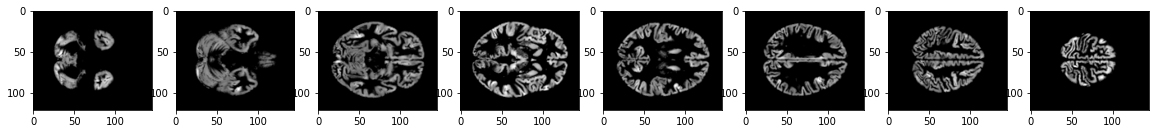

In [14]:
batchExample = dataGenerator([train_IXI.Loc.values,train_IXI.Scanner.values,train_IXI.Gender.values],train_IXI.Age.values, batch_size = 4, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False,maxAngle=40,maxShift=10)
tmp = batchExample.__getitem__(70)
print('Age: {} years'.format(tmp[1][0][0]))
plotData(tmp[0][0][:,:,:,:,:],c=2,d=10,nSlices=8)

In [15]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

for layer in model.layers[:19]:
    layer.trainable = False

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_absolute_error',optimizer=adam,metrics=['mae','mse'])

batchSize = 4
    
steps_per_epoch= train_IXI.shape[0]//batchSize
validation_steps = val_IXI.shape[0]//batchSize



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
nEpochs=250
mc = ModelCheckpoint('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType),verbose=1,mode='min',save_best_only=True)
early = EarlyStopping(patience=100, verbose=1)

In [ ]:
h = model.fit(dataGenerator([train_IXI.Loc.values,train_IXI.Scanner.values,train_IXI.Gender.values],train_IXI.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=True,augment=True,maxAngle=maxAngle,maxShift=maxShift),
                        validation_data=dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch, 
                        epochs=nEpochs,
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        callbacks=[mc,early]
                           )

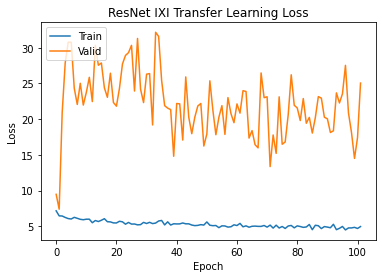

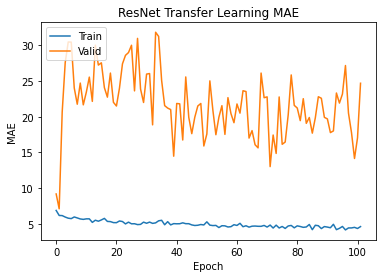

In [18]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('ResNet IXI Transfer Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])
plt.title('ResNet Transfer Learning MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

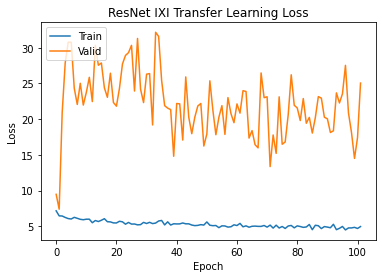

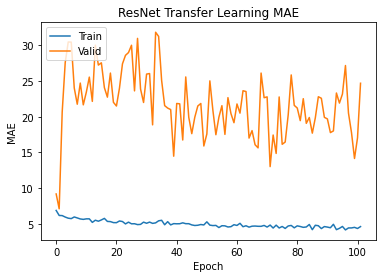

In [19]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('ResNet IXI Transfer Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])
plt.title('ResNet Transfer Learning MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

104/104 [==============================] - 4s 38ms/step
Validation R^2:  0.7398874166869513
Validation MAE:  6.991243881812462


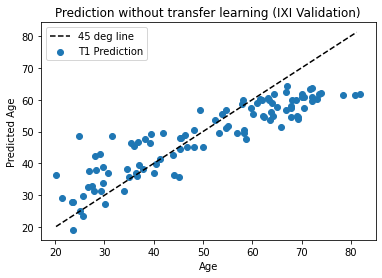

104/104 [==============================] - 4s 38ms/step
Validation R^2:  0.7145772092864744
Validation MAE:  7.089926260434664


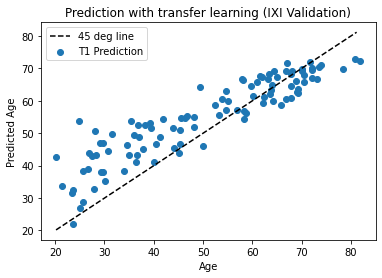

In [20]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

ixi_val_prediction_noTL = model.predict(dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ixi_val_prediction_noTL[:,0]
yVal = val_IXI.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction without transfer learning (IXI Validation)')
plt.legend()
plt.show()

model = load_model('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType))

ixi_val_prediction_TL = model.predict(dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ixi_val_prediction_TL[:,0]
yVal = val_IXI.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction with transfer learning (IXI Validation)')
plt.legend()
plt.show()

#### UK Biobank brian age prediction

In [21]:
ukb = getUKBData(imageType)

Age: 70.051 years


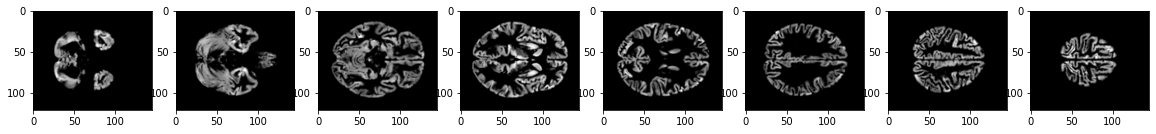

In [22]:
batchExample = dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 4, meanImg=None,dim=dataShape,shuffle=False,augment=False,maxAngle=40,maxShift=10)
tmp = batchExample.__getitem__(70)
print('Age: {} years'.format(tmp[1][0][0]))
plotData(tmp[0][0][:,:,:,:,:],c=2,d=10,nSlices=8)

Let's predict the age of the UK Biobank data using the ResNet trained on the Icelandic data only.

In [23]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

In [24]:
ukb_prediction_noTL = model.predict(dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

19642/19642 [==============================] - 643s 33ms/step


R^2:  -0.701379881145578
MAE:  8.59772185961878


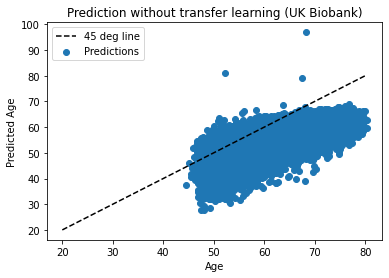

In [25]:
predictions = ukb_prediction_noTL[:,0]
y = ukb.Age.values 
print('R^2: ',r2_score(y,predictions))
print('MAE: ',mean_absolute_error(y,predictions))
plt.scatter(y,predictions,label='Predictions')
y_range = np.arange(20,np.max(y))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction without transfer learning (UK Biobank)')
plt.legend()
plt.show()

In [26]:
brainAge = pd.DataFrame({'PredictedBrainAge':np.array(predictions)},index = ukb['ID'])
brainAge.to_csv('../Results/{}_CNN_NoTL_pred.txt'.format(imageType),sep='\t')

Now let's try the model trained on the Icelandic data and IXI.

In [27]:
model = load_model('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType))

19642/19642 [==============================] - 636s 32ms/step
R^2:  0.4172617750147054
MAE:  4.586766158826117


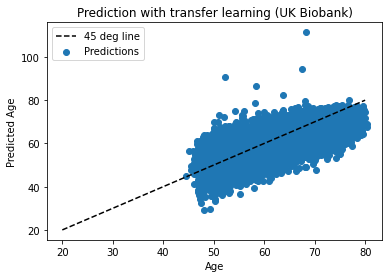

In [28]:
ukb_prediction_TL = model.predict(dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ukb_prediction_TL[:,0]
y = ukb.Age.values 
print('R^2: ',r2_score(y,predictions))
print('MAE: ',mean_absolute_error(y,predictions))

plt.scatter(y,predictions,label='Predictions')
y_range = np.arange(20,np.max(y))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction with transfer learning (UK Biobank)')
plt.legend()
plt.show()

In [29]:
brainAge = pd.DataFrame({'PredictedBrainAge':np.array(predictions)},index = ukb['ID'])
brainAge.to_csv('../Results/{}_CNN_WithTL_pred.txt'.format(imageType),sep='\t')